In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from sklearn.datasets import load_digits
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from typing import NewType

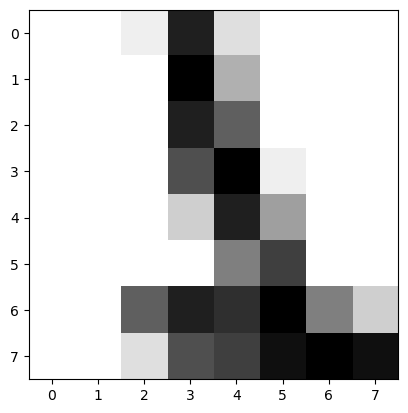

In [3]:
digits = load_digits(as_frame=True)
image_ = digits.data.iloc[1000].to_numpy().reshape(8, 8)
plt.imshow(image_, cmap='gray_r')

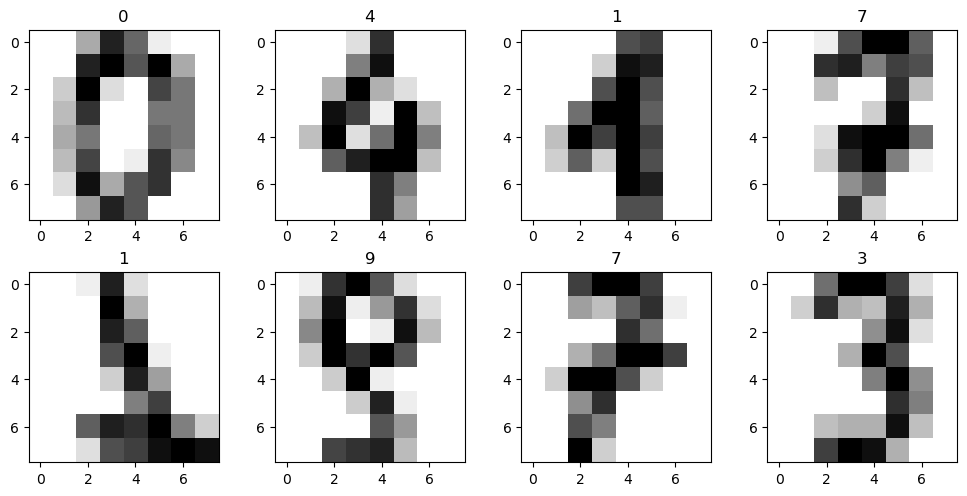

In [4]:
def reshape_image(row: int, df: pd.DataFrame)-> np.array:
    return df.iloc[row].to_numpy().reshape(8, 8)

rows = [0,100,200, 300, 1000, 1100, 1200, 1300]

images_reshaped = [reshape_image(row, digits.data) for row in rows]


Plot = NewType('Plot', plt.plot)

def plot_digits(images:np.array, row)-> Plot:
    
    fig_kw = {"tight_layout": True}
    
    grid_shape = int(len(images)/2)
    
    fig, ax = plt.subplots(nrows= 2, ncols = grid_shape, figsize = (10,5), **fig_kw)
    
    for image, ax, row in zip(images, ax.flatten(), rows):
        ax.imshow(image, cmap='gray_r')
        ax.set_title(digits.target[row])
        
    plt.show()
    
plot_digits(images_reshaped, rows)
                          



## Cross-validation of KNeighborsClassifier using K-fold range from 2-100

In [23]:


def xval_knn(data = digits.frame, features = digits.feature_names, 
                     target = 'target', k_fold = 5):
    
    kf = KFold(n_splits = k_fold, shuffle= True)
    
    test_acc = list()
    train_acc = list()
    for train_index, test_index in kf.split(data):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        knc = KNeighborsClassifier().fit(train[features], train[target])
        
        
        test_prediction = knc.predict(test[features])
        test_acc_score = accuracy_score(test[target], test_prediction)
        
        
        train_prediction = knc.predict(train[features])
        train_acc_score = accuracy_score(train[target], train_prediction)
                                       
        
        
        test_acc.append(test_acc_score)
        train_acc.append(train_acc_score)
        
    return np.mean(test_acc), np.mean(train_acc)
    
    
   
k_vals = range(2,100,10)
acc_scores = [xval_knn(k_fold = k) for k in k_vals]


In [40]:

def results_df(scores, col, col_name):
    test_scores = [scores[i][0] for i in range(len(scores))]
    train_scores = [scores[i][1] for i in range(len(scores))]
    results = pd.DataFrame(data =[col, test_scores, train_scores], index = [col_name, 'test_scores', 'train_scores']).T
    return pd.melt(results, id_vars = col_name, var_name ='score_type', value_name='score')


kn_results = results_df(scores = acc_scores, col = k_vals, col_name = 'k_vals')

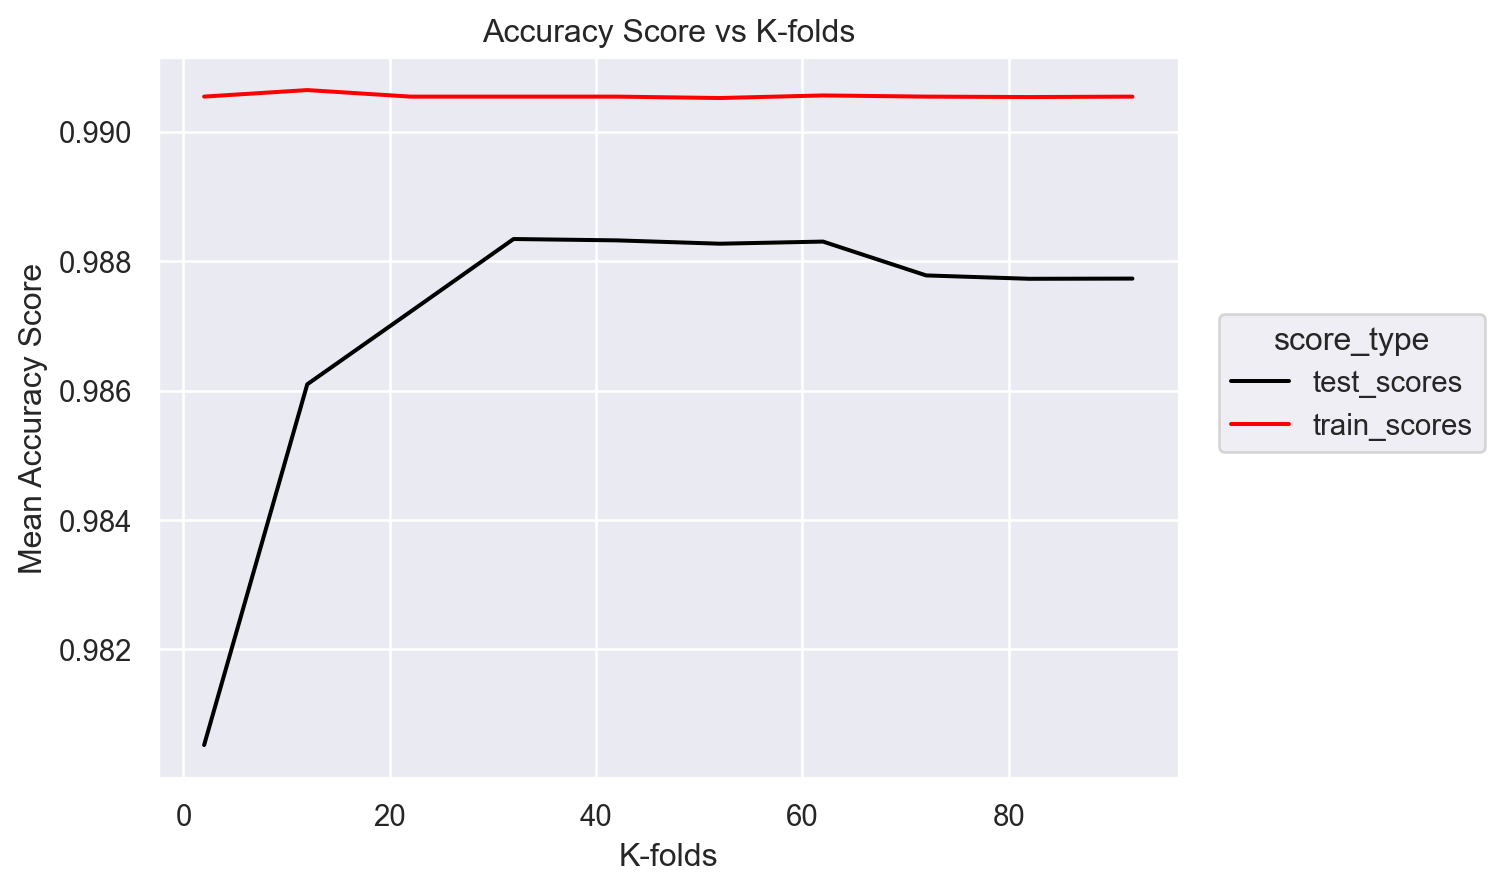

In [41]:
(
    so.Plot(data = kn_results, x = 'k_vals', y = 'score', color = 'score_type')
    .add(so.Line(linewidth = 1.5))
    .scale(color = ['black', 'red'])
    .label(x = 'K-folds', y = 'Mean Accuracy Score', title = 'Accuracy Score vs K-folds')
)


### Summary
---
Max accuracy score of KN classifier is acheived with ~40 fold cross validation, but appears to be prone to overfitting, given training scores are maxed at 0.99 at just 2 folds

## Multi-layer perception classifier (feedforwad MLP-NN)

In [7]:
def xval_MLP( layers, activation, data = digits.frame, features = digits.feature_names,
                     target = 'target', k_fold = 4):
    
    kf = KFold(n_splits = k_fold, shuffle= True)
    
    acc_test = []
    acc_train = []

    for train_index, test_index in kf.split(data):
        
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        mlp = MLPClassifier(hidden_layer_sizes=layers, activation=activation).fit(train[features], train[target])
        
        test_prediction = mlp.predict(test[features])
        train_prediction = mlp.predict(train[features])
        
        acc_score_test = accuracy_score(test[target], test_prediction)
        acc_score_train = accuracy_score(train[target], train_prediction)
        acc_test.append(acc_score_test)
        acc_train.append(acc_score_train)
        
    
        
    return np.mean(acc_test), np.mean(acc_train)
    
    

In [8]:
neurons = [8,16,32,64,128,256]
mlp_acc = [xval_MLP(layers = (n,), activation = 'relu') for n in neurons]

c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mds8301

In [43]:

mlp_layer1_results = results_df(scores = mlp_acc, col = neurons, col_name = 'neurons')

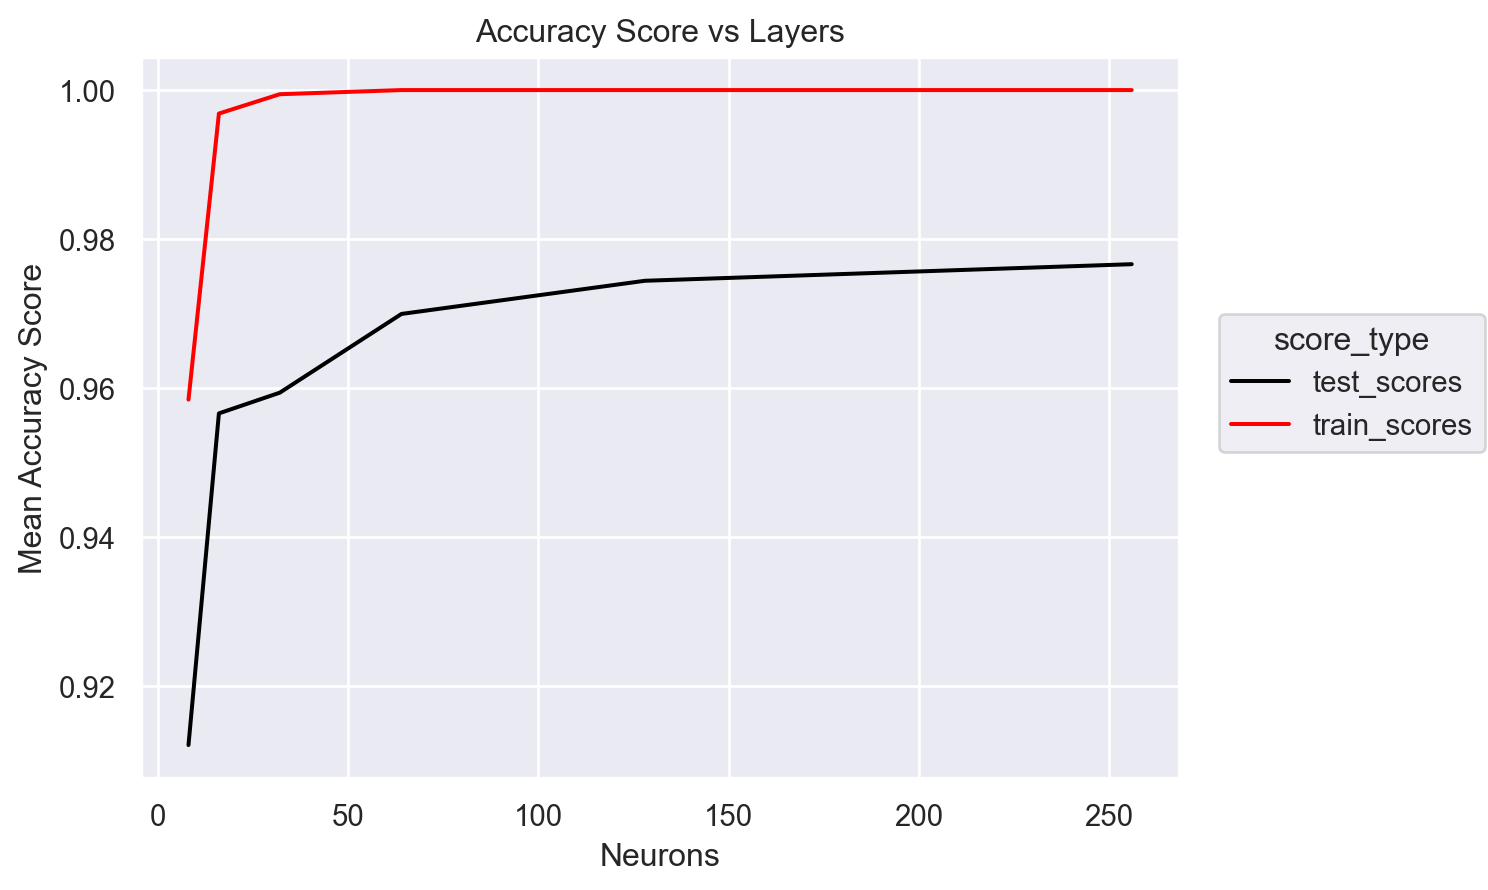

In [44]:
(
    so.Plot(data = mlp_layer1_results, x= 'neurons', y = 'score', color = 'score_type')
    .add(so.Line(linewidth = 1.5))
    .scale(color = ['black', 'red'])
    .label(x = 'Neurons', y = 'Mean Accuracy Score', title = 'Accuracy Score vs Layers')
)


## MLP Sumarry
---
Clear overfitting at as early as 16 layers. 8 layers likley to produce best results

## MLP test of 2 layers with 64 neurons each, with 4-fold cross-validation increasting testing performace, with training performace at 100%

In [32]:
mlp_64_64 = xval_MLP(layers = (64,64), activation = 'relu')

In [35]:
three_layer_n = [10,64,128]
three_layer_scores = [xval_MLP(layers = (n,n,n), activation = 'relu') for n in three_layer_n]

c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\mds8301\Anaconda3\envs\digits\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [48]:
layer_3_results = results_df(scores = three_layer_scores, col = three_layer_n, col_name = 'neurons')
layer_3_results

,neurons,score_type,score
0,10.0,test_scores,0.924319
1,64.0,test_scores,0.969392
2,128.0,test_scores,0.978295
3,10.0,train_scores,0.989798
4,64.0,train_scores,1.000000
5,128.0,train_scores,1.000000


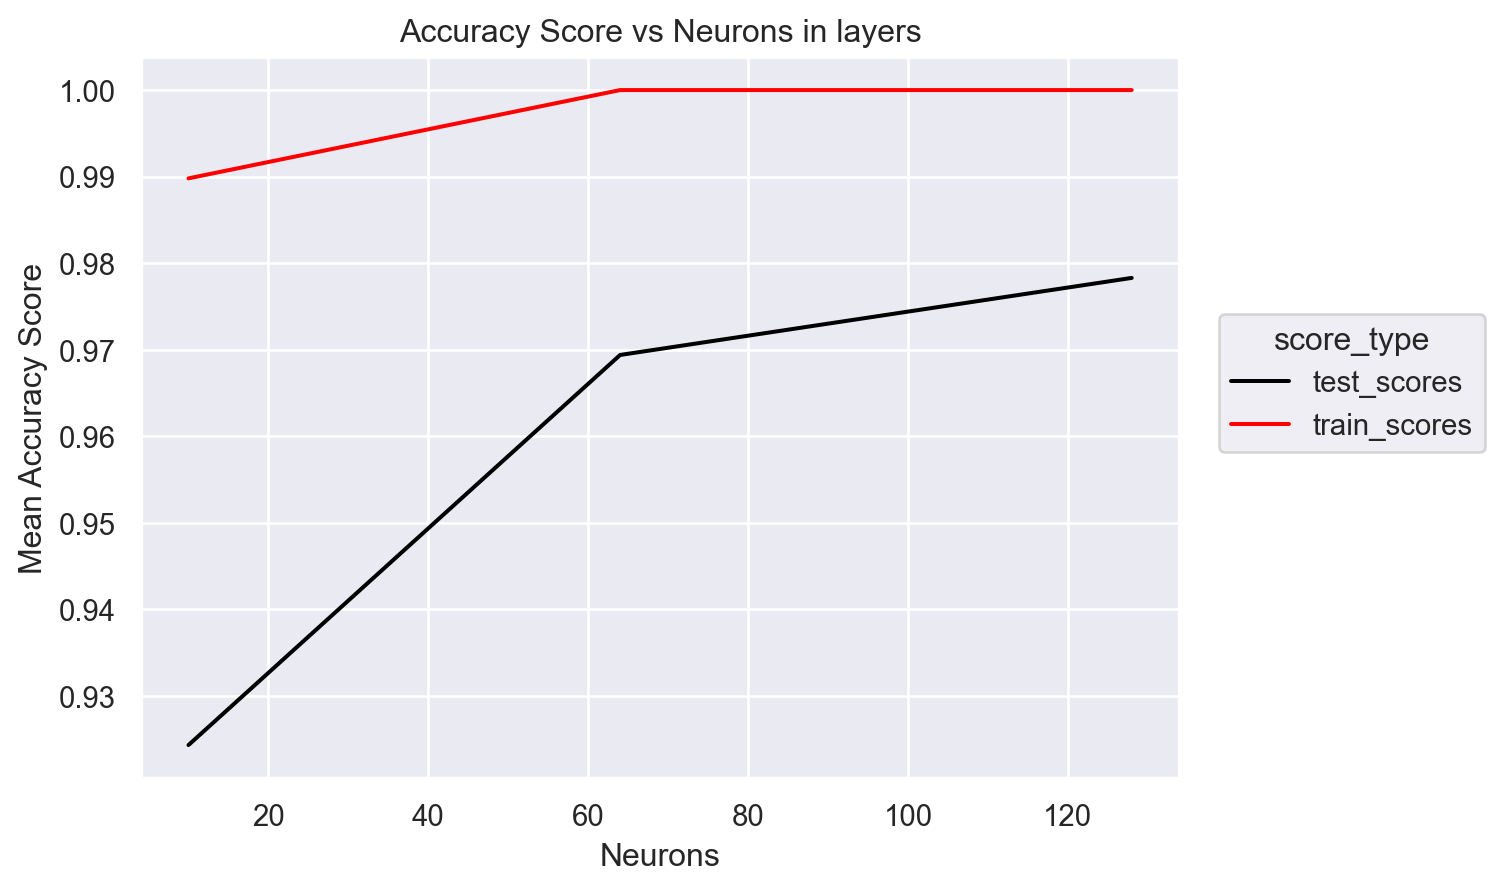

In [50]:
(
    so.Plot(data = layer_3_results, x= 'neurons', y = 'score', color = 'score_type')
    .add(so.Line(linewidth = 1.5))
    .scale(color = ['black', 'red'])
    .label(x = 'Neurons', y = 'Mean Accuracy Score', title = 'Accuracy Score vs Neurons in layers')
)

In review we find that that the MLP classifer  performs optinmally with single layer and low neuron counts, likely due to clarity and cleanliness of the data source. Higher layer number and neuron counts results in overfitting